In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import datetime
import torch
from torch.nn import functional as F
import scipy.stats
import sklearn.datasets

import sys
sys.path.append("../")
import curvvae_lib.train.predictive_passthrough_trainer as ppttrainer
import curvvae_lib.architecture.passthrough_vae as ptvae
import curvvae_lib.architecture.save_model as sm
import curvvae_lib.architecture.load_model as lm

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-e4b2xlya because the default path (/home/tsr42/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# Dataset

In [2]:
foodname = "banana"
foldername = f"fork_trajectory_{foodname}"
savefilename = f"{foodname}_clean_pickups"

In [23]:
train = []
training_ts = np.linspace(0,1,64)
attempt = 1
while True:
    try:
        raw_vals = np.load(f"{savefilename}/pickup_attempt{attempt}.npy")
        train.append(raw_vals.T.flatten())
    except:
        print(f"We found {attempt-1} pickup attempts")
        break
    attempt += 1

train = np.array(train).reshape(-1,7,64)
all_points = train[:,:,:]

time_shape = list(all_points.shape)
time_shape[1] = 1
# why be smart when you can be dumb
t = np.ones(time_shape)
for i in range(time_shape[2]):
    t[:,:,i] = t[:,:,i] * i / (time_shape[2] + 0.0)

all_points = np.concatenate((t, all_points), axis=1)
all_points = all_points.transpose(0,2,1)

start_points = all_points[:,0,1:]
# See http://localhost:8889/notebooks/scratchwork/2021-09-17%20Rotation%20Scaling.ipynb
# for why we want quaternion values to be multiplied by 0.16 when position values are in meters 
# (if the relevant distance scale of the fork is 0.08 meters, ie: 8cm).
mean = np.mean(start_points, axis=0)
variance = np.var(start_points, axis=0)
position_std = np.sqrt(np.max(variance))
print("std of: ", position_std)
position_scaling = 1/position_std
rotation_scaling = 0.16 * position_scaling

start_points = start_points - mean
poss = position_scaling
rts = rotation_scaling
start_points = (start_points * np.array((poss,poss,poss,rts,rts,rts,rts)))
print("shape before reducing dimension", all_points.shape)
print("dataset variance of:", np.var(start_points,axis=0))

We found 154 pickup attempts
std of:  0.17447834259676462
shape before reducing dimension (154, 64, 8)
dataset variance of: [0.00197013 0.0012774  0.00135245 0.00687806 0.0256     0.00588592
 0.00669464]


In [24]:
dataset = start_points
dataset

array([[ 0.03644411, -0.05664173, -0.01726175, ...,  0.05311595,
         0.03802196,  0.04693789],
       [-0.07453766, -0.01680912, -0.0215112 , ..., -0.05982878,
        -0.04222452, -0.07548245],
       [ 0.00971311, -0.02070482, -0.03210563, ...,  0.05624359,
         0.00829467,  0.04349922],
       ...,
       [-0.01814567,  0.012406  , -0.01415396, ..., -0.08273447,
        -0.04929883,  0.05353723],
       [-0.0386492 ,  0.02261964,  0.00349406, ..., -0.24490761,
        -0.07656989,  0.03259478],
       [ 0.01510075, -0.00209672, -0.00561974, ...,  0.21811145,
         0.10821248,  0.05325818]])

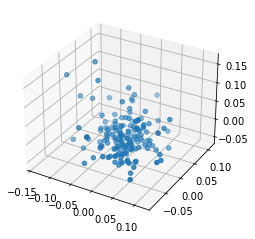

In [25]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(dataset[:,0],dataset[:,1],dataset[:,2]);

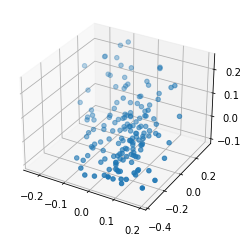

In [26]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(dataset[:,3],dataset[:,4],dataset[:,5]);

## 2D VAE Fit to Dataset

In [6]:
def LoadDataBatch(all_points, batchsize, passthroughdim, predictive, device):
    """Sample Pair of Points from Trajectory"""
    # all_points should be of dimension: num_trajectories, numtimesteps, 1+spatialdims
    traj_ids = np.random.choice(all_points.shape[0], batchsize)
    t1_ids = np.random.choice(all_points.shape[1], batchsize)
    if predictive:
        t2_ids = np.random.choice(all_points.shape[1], batchsize)
    else:
        t2_ids = t1_ids
    return (torch.tensor(all_points[traj_ids, t1_ids,passthroughdim:], dtype=torch.float).to(device),
            torch.tensor(all_points[traj_ids, t1_ids,:passthroughdim], dtype=torch.float).to(device),
            torch.tensor(all_points[traj_ids, t2_ids,passthroughdim:], dtype=torch.float).to(device),
            torch.tensor(all_points[traj_ids, t2_ids,:passthroughdim], dtype=torch.float).to(device))

In [7]:
class Loader(object):
    def __init__(self, all_points, batchsize, passthroughdim, epochnumbatches, predictive, device):
        self.all_points = all_points
        self.batchsize = batchsize
        self.passthroughdim = passthroughdim
        self.epochnumbatches = epochnumbatches
        self.predictive = predictive
        self.device = device
        
    def __iter__(self):
        self.n = 0
        return self
    
    def __next__(self):
        if self.n >= self.epochnumbatches:
            # https://docs.python.org/3/library/exceptions.html#StopIteration
            raise StopIteration
        self.n += 1
        return LoadDataBatch(self.all_points, self.batchsize, self.passthroughdim, self.predictive, self.device)
    

device = "cuda"
train_loader = Loader(dataset[:,np.newaxis,:], 256, 0,10,predictive=False, device=device)
  

In [8]:
dataset_dim = dataset.shape[-1]
def make_vae(latent_dim):
    input_dim = dataset_dim 
    passthrough_dim = 0
    emb_layer_widths = [1000]
    recon_layer_widths = [1000]
    dtype = torch.float
    model = ptvae.FCPassthroughVAE(input_dim, passthrough_dim, latent_dim,
        emb_layer_widths, recon_layer_widths, dtype)
    return model

In [9]:
testname = "pedagogicalstartpts/startpts"

In [10]:
all_models=[
'pedagogicalstartpts/startptslat2_lr0.0001_curvreg0_beta1_20220207-121542',
'pedagogicalstartpts/startptslat2_lr0.0001_curvreg1_beta1_20220207-121623',
'pedagogicalstartpts/startptslat2_lr0.0001_curvreg10_beta1_20220207-121716',
'pedagogicalstartpts/startptslat2_lr0.0001_curvreg50_beta1_20220207-121810',
'pedagogicalstartpts/startptslat2_lr0.0001_curvreg100_beta1_20220207-121904',
'pedagogicalstartpts/startptslat2_lr0.0001_curvreg0_beta0.0001_20220207-121959',
'pedagogicalstartpts/startptslat2_lr0.0001_curvreg1_beta0.0001_20220207-122038',
'pedagogicalstartpts/startptslat2_lr0.0001_curvreg10_beta0.0001_20220207-122132',
'pedagogicalstartpts/startptslat2_lr0.0001_curvreg50_beta0.0001_20220207-122227',
'pedagogicalstartpts/startptslat2_lr0.0001_curvreg100_beta0.0001_20220207-122321',
'pedagogicalstartpts/startptslat2_lr0.0001_curvreg0_beta0.01_20220207-122414',
'pedagogicalstartpts/startptslat2_lr0.0001_curvreg1_beta0.01_20220207-122453',
'pedagogicalstartpts/startptslat2_lr0.0001_curvreg10_beta0.01_20220207-122547',
'pedagogicalstartpts/startptslat2_lr0.0001_curvreg50_beta0.01_20220207-122644',
'pedagogicalstartpts/startptslat2_lr0.0001_curvreg100_beta0.01_20220207-122738',
'pedagogicalstartpts/startptslat2_lr0.0001_curvreg0_beta1.5_20220207-122834',
'pedagogicalstartpts/startptslat2_lr0.0001_curvreg1_beta1.5_20220207-122913',
'pedagogicalstartpts/startptslat2_lr0.0001_curvreg10_beta1.5_20220207-123008',
'pedagogicalstartpts/startptslat2_lr0.0001_curvreg50_beta1.5_20220207-123102',
'pedagogicalstartpts/startptslat2_lr0.0001_curvreg100_beta1.5_20220207-123157',
'pedagogicalstartpts/startptslat2_lr0.0001_curvreg0_beta2_20220207-123255',
'pedagogicalstartpts/startptslat2_lr0.0001_curvreg1_beta2_20220207-123335',
'pedagogicalstartpts/startptslat2_lr0.0001_curvreg10_beta2_20220207-123429',
'pedagogicalstartpts/startptslat2_lr0.0001_curvreg50_beta2_20220207-123523',
'pedagogicalstartpts/startptslat2_lr0.0001_curvreg100_beta2_20220207-123622',
'pedagogicalstartpts/startptslat2_lr0.0001_curvreg0_beta0.1_20220207-123717',
'pedagogicalstartpts/startptslat2_lr0.0001_curvreg1_beta0.1_20220207-123757',
'pedagogicalstartpts/startptslat2_lr0.0001_curvreg10_beta0.1_20220207-123852',
'pedagogicalstartpts/startptslat2_lr0.0001_curvreg50_beta0.1_20220207-123948',
'pedagogicalstartpts/startptslat2_lr0.0001_curvreg100_beta0.1_20220207-124042',
'pedagogicalstartpts/startptslat2_lr1e-05_curvreg0_beta1_20220207-124137',
'pedagogicalstartpts/startptslat2_lr1e-05_curvreg1_beta1_20220207-124217',
'pedagogicalstartpts/startptslat2_lr1e-05_curvreg10_beta1_20220207-124312',
'pedagogicalstartpts/startptslat2_lr1e-05_curvreg50_beta1_20220207-124406',
'pedagogicalstartpts/startptslat2_lr1e-05_curvreg100_beta1_20220207-124501',
'pedagogicalstartpts/startptslat2_lr1e-05_curvreg0_beta0.0001_20220207-124555',
'pedagogicalstartpts/startptslat2_lr1e-05_curvreg1_beta0.0001_20220207-124635',
'pedagogicalstartpts/startptslat2_lr1e-05_curvreg10_beta0.0001_20220207-124729',
'pedagogicalstartpts/startptslat2_lr1e-05_curvreg50_beta0.0001_20220207-124824',
'pedagogicalstartpts/startptslat2_lr1e-05_curvreg100_beta0.0001_20220207-124919',
'pedagogicalstartpts/startptslat2_lr1e-05_curvreg0_beta0.01_20220207-125013',
'pedagogicalstartpts/startptslat2_lr1e-05_curvreg1_beta0.01_20220207-125053',
'pedagogicalstartpts/startptslat2_lr1e-05_curvreg10_beta0.01_20220207-125147',
'pedagogicalstartpts/startptslat2_lr1e-05_curvreg50_beta0.01_20220207-125242'
]

In [11]:

colors=["red","yellow","green","orange","black","gray","blue"]

In [12]:
def make_2d_grid_points(xmin, xmax, ymin, ymax, ):
    #lim = 6
    num_few = 7
    num_many = 100
    pts = []
    for x in np.linspace(xmin, xmax, num_few):
        for y in np.linspace(ymin, ymax, num_many):
                pts.append((x,y))
    for y in np.linspace(ymin, ymax, num_few):
        for x in np.linspace(xmin, xmax, num_many):
                pts.append((x,y))
    return np.array(pts)

pedagogicalstartpts/startptslat2_lr0.0001_curvreg0_beta1_20220207-121542
(154, 2)


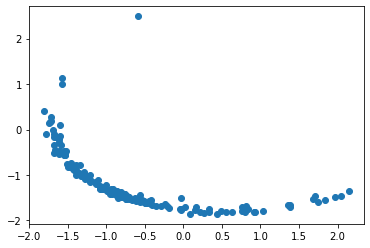

pedagogicalstartpts/startptslat2_lr0.0001_curvreg1_beta1_20220207-121623
(154, 2)


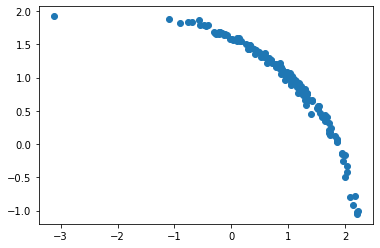

pedagogicalstartpts/startptslat2_lr0.0001_curvreg10_beta1_20220207-121716
(154, 2)


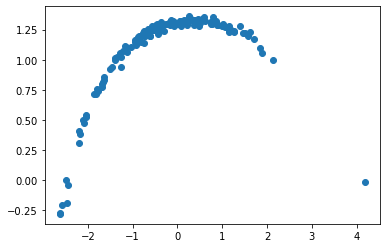

pedagogicalstartpts/startptslat2_lr0.0001_curvreg50_beta1_20220207-121810
(154, 2)


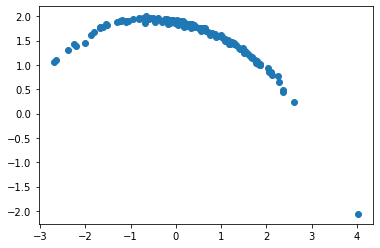

pedagogicalstartpts/startptslat2_lr0.0001_curvreg100_beta1_20220207-121904
(154, 2)


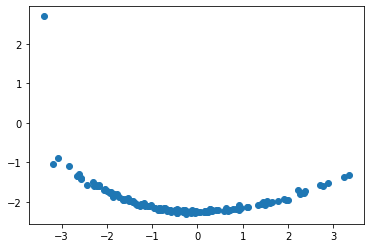

pedagogicalstartpts/startptslat2_lr0.0001_curvreg0_beta0.0001_20220207-121959
(154, 2)


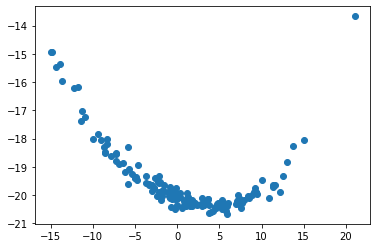

pedagogicalstartpts/startptslat2_lr0.0001_curvreg1_beta0.0001_20220207-122038
(154, 2)


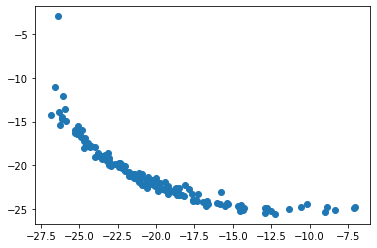

pedagogicalstartpts/startptslat2_lr0.0001_curvreg10_beta0.0001_20220207-122132
(154, 2)


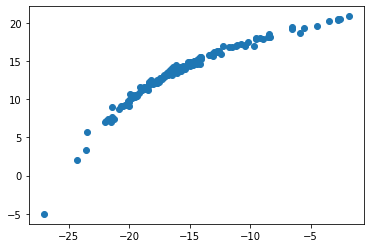

pedagogicalstartpts/startptslat2_lr0.0001_curvreg50_beta0.0001_20220207-122227
(154, 2)


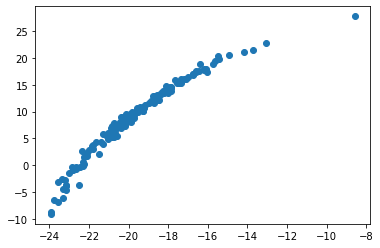

pedagogicalstartpts/startptslat2_lr0.0001_curvreg100_beta0.0001_20220207-122321
(154, 2)


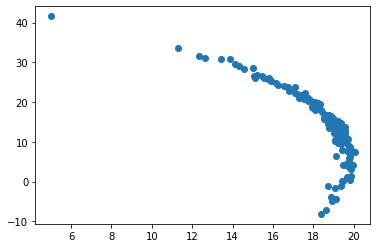

pedagogicalstartpts/startptslat2_lr0.0001_curvreg0_beta0.01_20220207-122414
(154, 2)


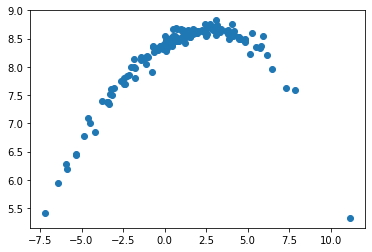

pedagogicalstartpts/startptslat2_lr0.0001_curvreg1_beta0.01_20220207-122453
(154, 2)


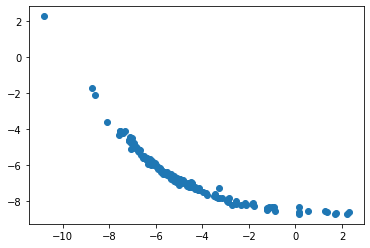

pedagogicalstartpts/startptslat2_lr0.0001_curvreg10_beta0.01_20220207-122547
(154, 2)


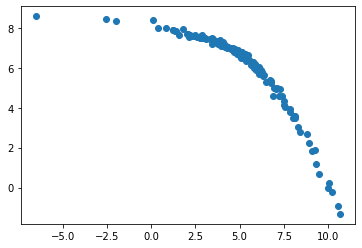

pedagogicalstartpts/startptslat2_lr0.0001_curvreg50_beta0.01_20220207-122644
(154, 2)


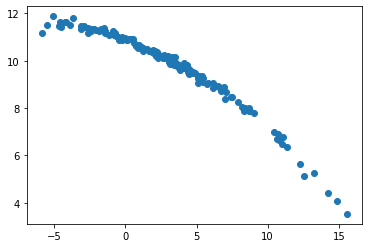

pedagogicalstartpts/startptslat2_lr0.0001_curvreg100_beta0.01_20220207-122738
(154, 2)


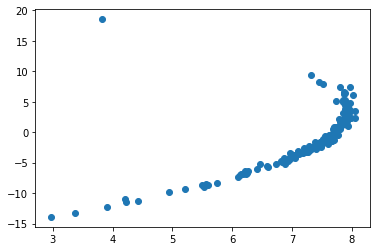

pedagogicalstartpts/startptslat2_lr0.0001_curvreg0_beta1.5_20220207-122834
(154, 2)


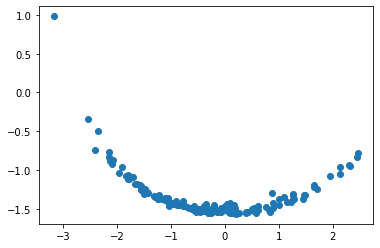

pedagogicalstartpts/startptslat2_lr0.0001_curvreg1_beta1.5_20220207-122913
(154, 2)


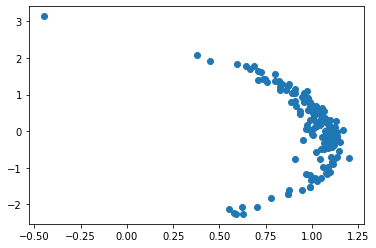

pedagogicalstartpts/startptslat2_lr0.0001_curvreg10_beta1.5_20220207-123008
(154, 2)


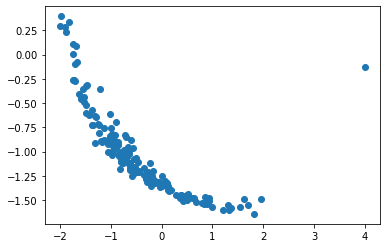

pedagogicalstartpts/startptslat2_lr0.0001_curvreg50_beta1.5_20220207-123102
(154, 2)


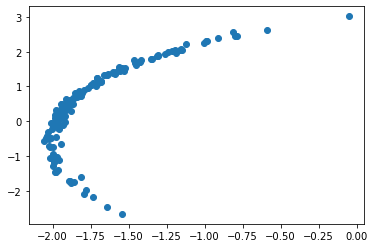

pedagogicalstartpts/startptslat2_lr0.0001_curvreg100_beta1.5_20220207-123157
(154, 2)


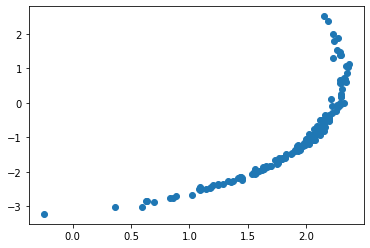

pedagogicalstartpts/startptslat2_lr0.0001_curvreg0_beta2_20220207-123255
(154, 2)


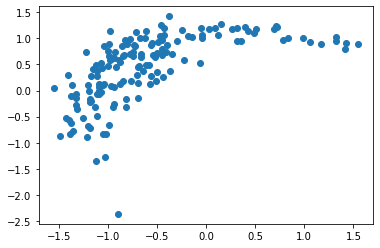

pedagogicalstartpts/startptslat2_lr0.0001_curvreg1_beta2_20220207-123335
(154, 2)


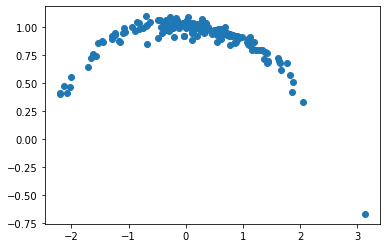

pedagogicalstartpts/startptslat2_lr0.0001_curvreg10_beta2_20220207-123429
(154, 2)


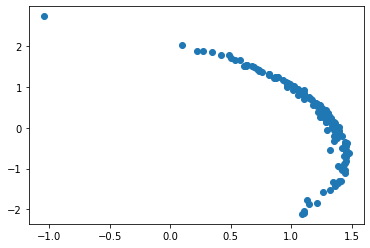

pedagogicalstartpts/startptslat2_lr0.0001_curvreg50_beta2_20220207-123523
(154, 2)


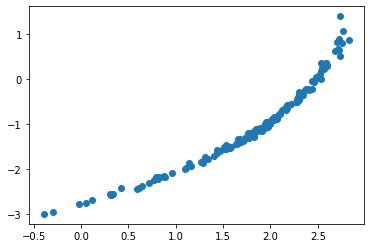

pedagogicalstartpts/startptslat2_lr0.0001_curvreg100_beta2_20220207-123622
(154, 2)


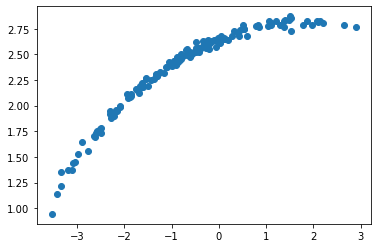

pedagogicalstartpts/startptslat2_lr0.0001_curvreg0_beta0.1_20220207-123717
(154, 2)


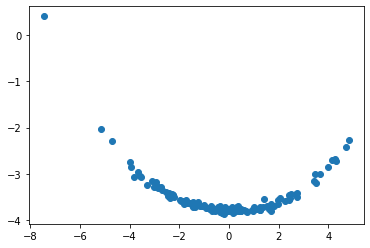

pedagogicalstartpts/startptslat2_lr0.0001_curvreg1_beta0.1_20220207-123757
(154, 2)


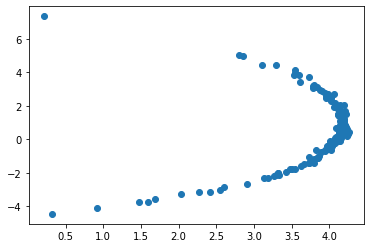

pedagogicalstartpts/startptslat2_lr0.0001_curvreg10_beta0.1_20220207-123852
(154, 2)


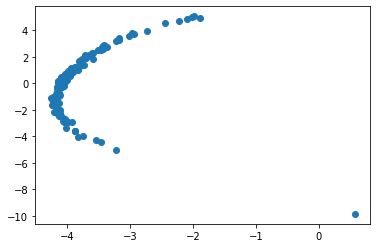

pedagogicalstartpts/startptslat2_lr0.0001_curvreg50_beta0.1_20220207-123948
(154, 2)


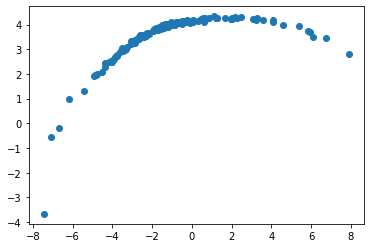

pedagogicalstartpts/startptslat2_lr0.0001_curvreg100_beta0.1_20220207-124042
(154, 2)


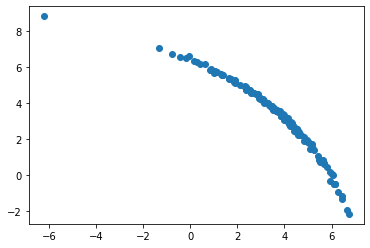

pedagogicalstartpts/startptslat2_lr1e-05_curvreg0_beta1_20220207-124137
(154, 2)


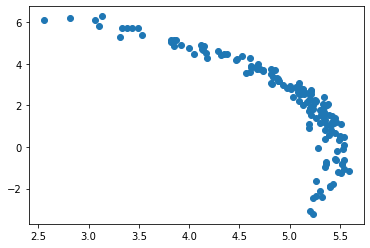

pedagogicalstartpts/startptslat2_lr1e-05_curvreg1_beta1_20220207-124217
(154, 2)


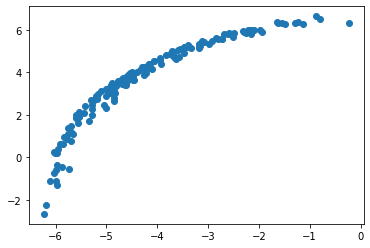

pedagogicalstartpts/startptslat2_lr1e-05_curvreg10_beta1_20220207-124312
(154, 2)


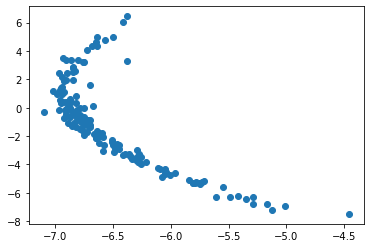

pedagogicalstartpts/startptslat2_lr1e-05_curvreg50_beta1_20220207-124406
(154, 2)


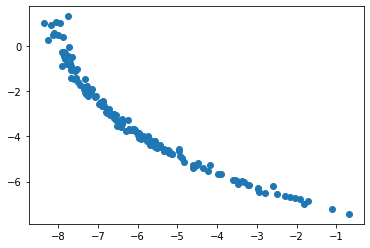

pedagogicalstartpts/startptslat2_lr1e-05_curvreg100_beta1_20220207-124501
(154, 2)


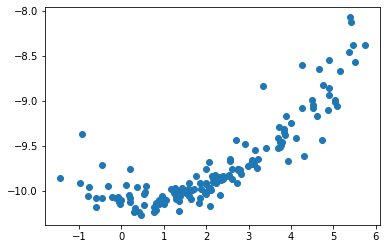

pedagogicalstartpts/startptslat2_lr1e-05_curvreg0_beta0.0001_20220207-124555
(154, 2)


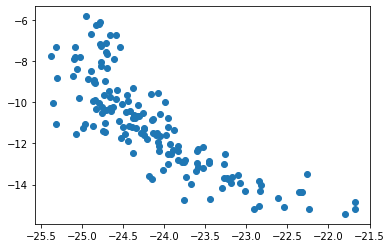

pedagogicalstartpts/startptslat2_lr1e-05_curvreg1_beta0.0001_20220207-124635
(154, 2)


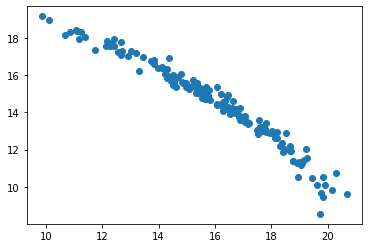

pedagogicalstartpts/startptslat2_lr1e-05_curvreg10_beta0.0001_20220207-124729
(154, 2)


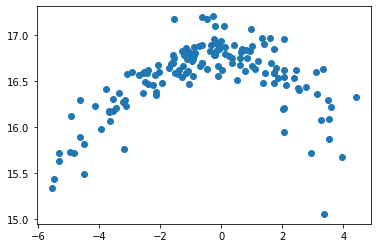

pedagogicalstartpts/startptslat2_lr1e-05_curvreg50_beta0.0001_20220207-124824
(154, 2)


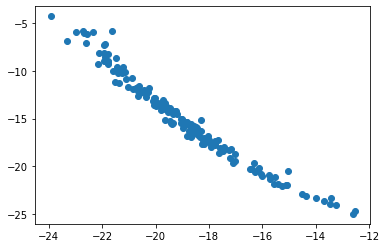

pedagogicalstartpts/startptslat2_lr1e-05_curvreg100_beta0.0001_20220207-124919
(154, 2)


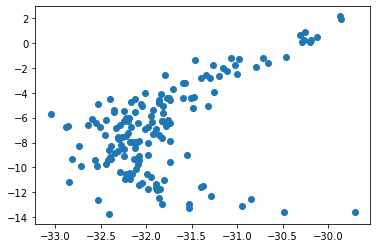

pedagogicalstartpts/startptslat2_lr1e-05_curvreg0_beta0.01_20220207-125013
(154, 2)


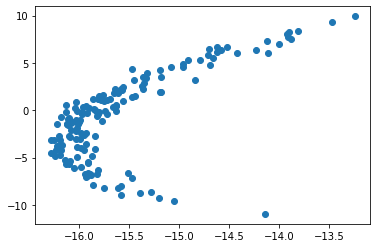

pedagogicalstartpts/startptslat2_lr1e-05_curvreg1_beta0.01_20220207-125053
(154, 2)


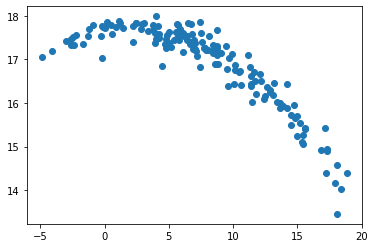

pedagogicalstartpts/startptslat2_lr1e-05_curvreg10_beta0.01_20220207-125147
(154, 2)


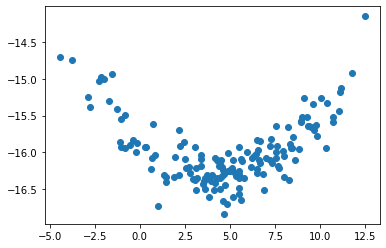

pedagogicalstartpts/startptslat2_lr1e-05_curvreg50_beta0.01_20220207-125242
(154, 2)


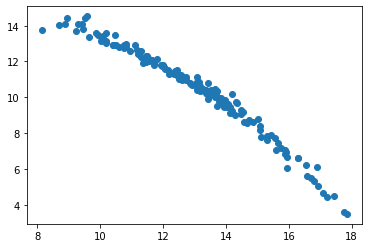

In [13]:
for i, modelpath in enumerate(all_models):
    fig = plt.figure()
    print(modelpath)
    vae = lm.load_model(modelpath)
    embeds = vae.encode(torch.tensor(dataset,dtype=torch.float),
                       torch.tensor(np.zeros((len(dataset),0)),dtype=torch.float)
                       )[0].detach().cpu().numpy()
    print(embeds.shape)
    plt.scatter(embeds[:,0],embeds[:,1]);
    plt.show()
    plt.close()

pedagogicalstartpts/startptslat2_lr0.0001_curvreg0_beta1_20220207-121542


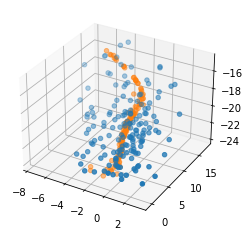

pedagogicalstartpts/startptslat2_lr0.0001_curvreg1_beta1_20220207-121623


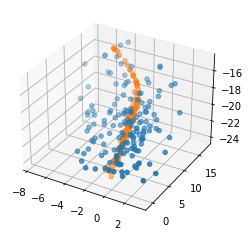

pedagogicalstartpts/startptslat2_lr0.0001_curvreg10_beta1_20220207-121716


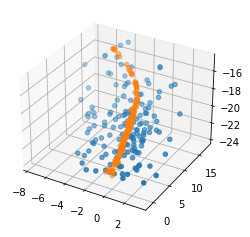

pedagogicalstartpts/startptslat2_lr0.0001_curvreg50_beta1_20220207-121810


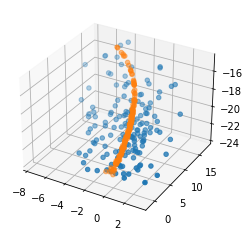

pedagogicalstartpts/startptslat2_lr0.0001_curvreg100_beta1_20220207-121904


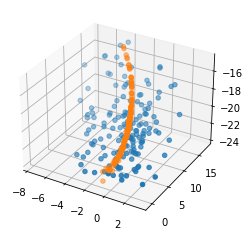

pedagogicalstartpts/startptslat2_lr0.0001_curvreg0_beta0.0001_20220207-121959


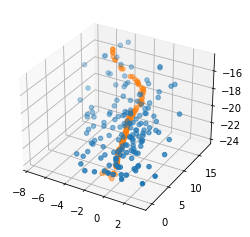

pedagogicalstartpts/startptslat2_lr0.0001_curvreg1_beta0.0001_20220207-122038


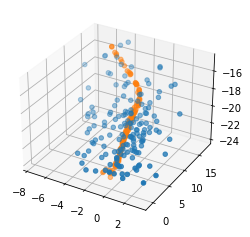

pedagogicalstartpts/startptslat2_lr0.0001_curvreg10_beta0.0001_20220207-122132


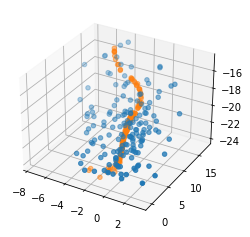

pedagogicalstartpts/startptslat2_lr0.0001_curvreg50_beta0.0001_20220207-122227


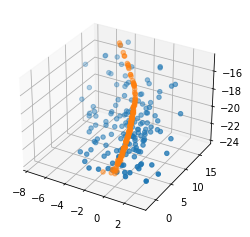

pedagogicalstartpts/startptslat2_lr0.0001_curvreg100_beta0.0001_20220207-122321


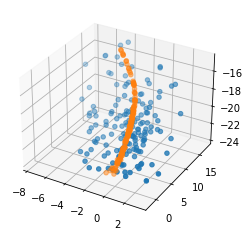

pedagogicalstartpts/startptslat2_lr0.0001_curvreg0_beta0.01_20220207-122414


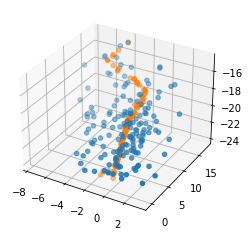

pedagogicalstartpts/startptslat2_lr0.0001_curvreg1_beta0.01_20220207-122453


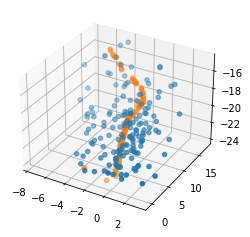

pedagogicalstartpts/startptslat2_lr0.0001_curvreg10_beta0.01_20220207-122547


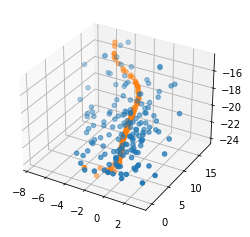

pedagogicalstartpts/startptslat2_lr0.0001_curvreg50_beta0.01_20220207-122644


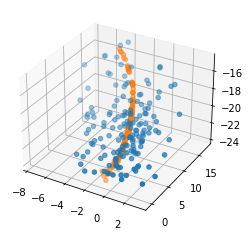

pedagogicalstartpts/startptslat2_lr0.0001_curvreg100_beta0.01_20220207-122738


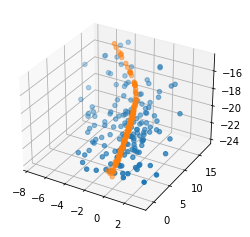

pedagogicalstartpts/startptslat2_lr0.0001_curvreg0_beta1.5_20220207-122834


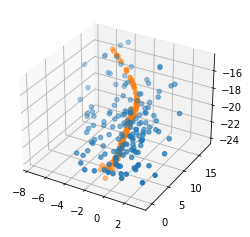

pedagogicalstartpts/startptslat2_lr0.0001_curvreg1_beta1.5_20220207-122913


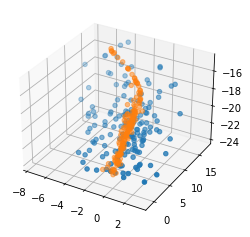

pedagogicalstartpts/startptslat2_lr0.0001_curvreg10_beta1.5_20220207-123008


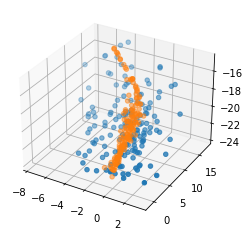

pedagogicalstartpts/startptslat2_lr0.0001_curvreg50_beta1.5_20220207-123102


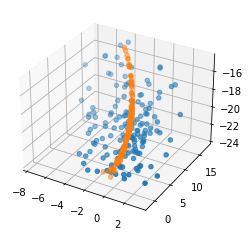

pedagogicalstartpts/startptslat2_lr0.0001_curvreg100_beta1.5_20220207-123157


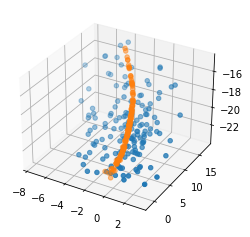

pedagogicalstartpts/startptslat2_lr0.0001_curvreg0_beta2_20220207-123255


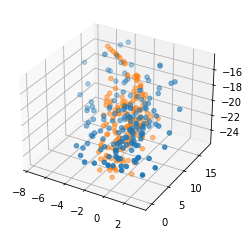

pedagogicalstartpts/startptslat2_lr0.0001_curvreg1_beta2_20220207-123335


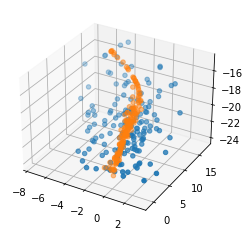

pedagogicalstartpts/startptslat2_lr0.0001_curvreg10_beta2_20220207-123429


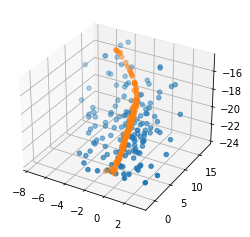

pedagogicalstartpts/startptslat2_lr0.0001_curvreg50_beta2_20220207-123523


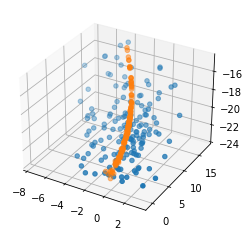

pedagogicalstartpts/startptslat2_lr0.0001_curvreg100_beta2_20220207-123622


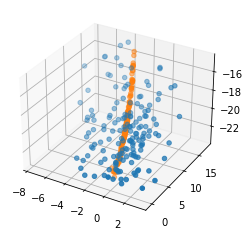

pedagogicalstartpts/startptslat2_lr0.0001_curvreg0_beta0.1_20220207-123717


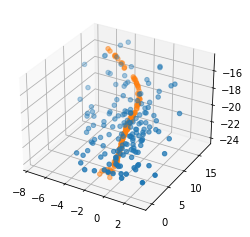

pedagogicalstartpts/startptslat2_lr0.0001_curvreg1_beta0.1_20220207-123757


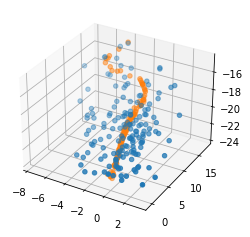

pedagogicalstartpts/startptslat2_lr0.0001_curvreg10_beta0.1_20220207-123852


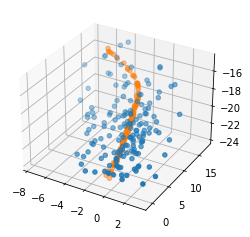

pedagogicalstartpts/startptslat2_lr0.0001_curvreg50_beta0.1_20220207-123948


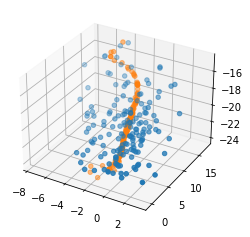

pedagogicalstartpts/startptslat2_lr0.0001_curvreg100_beta0.1_20220207-124042


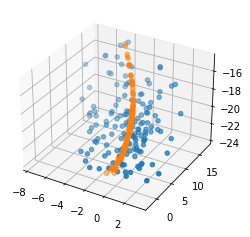

pedagogicalstartpts/startptslat2_lr1e-05_curvreg0_beta1_20220207-124137


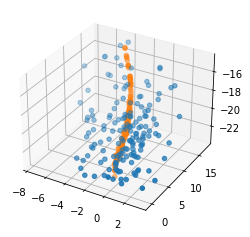

pedagogicalstartpts/startptslat2_lr1e-05_curvreg1_beta1_20220207-124217


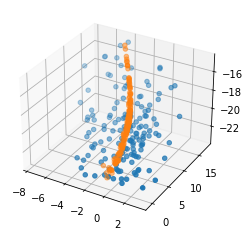

pedagogicalstartpts/startptslat2_lr1e-05_curvreg10_beta1_20220207-124312


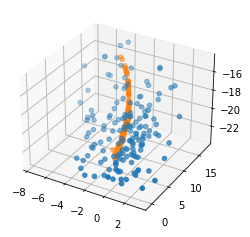

pedagogicalstartpts/startptslat2_lr1e-05_curvreg50_beta1_20220207-124406


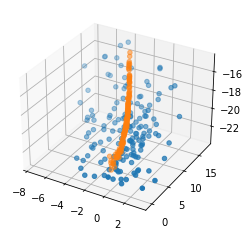

pedagogicalstartpts/startptslat2_lr1e-05_curvreg100_beta1_20220207-124501


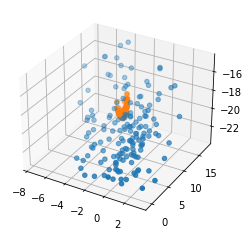

pedagogicalstartpts/startptslat2_lr1e-05_curvreg0_beta0.0001_20220207-124555


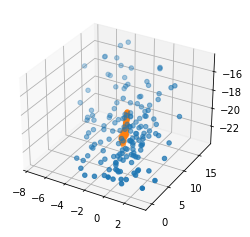

pedagogicalstartpts/startptslat2_lr1e-05_curvreg1_beta0.0001_20220207-124635


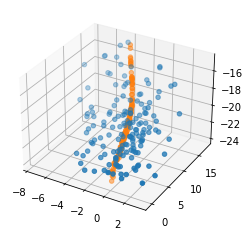

pedagogicalstartpts/startptslat2_lr1e-05_curvreg10_beta0.0001_20220207-124729


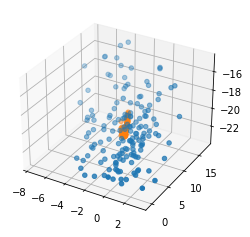

pedagogicalstartpts/startptslat2_lr1e-05_curvreg50_beta0.0001_20220207-124824


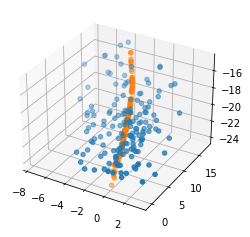

pedagogicalstartpts/startptslat2_lr1e-05_curvreg100_beta0.0001_20220207-124919


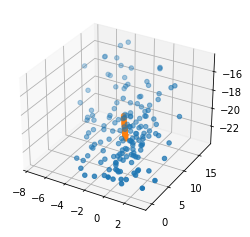

pedagogicalstartpts/startptslat2_lr1e-05_curvreg0_beta0.01_20220207-125013


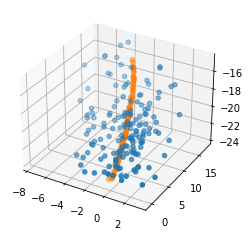

pedagogicalstartpts/startptslat2_lr1e-05_curvreg1_beta0.01_20220207-125053


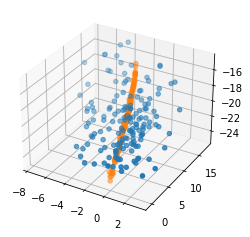

pedagogicalstartpts/startptslat2_lr1e-05_curvreg10_beta0.01_20220207-125147


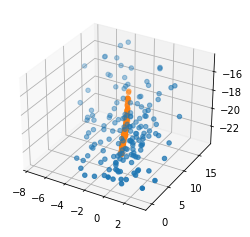

pedagogicalstartpts/startptslat2_lr1e-05_curvreg50_beta0.01_20220207-125242


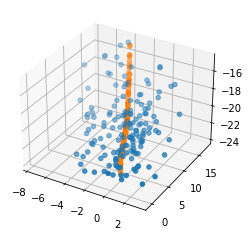

In [14]:

for i, modelpath in enumerate(all_models):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    print(modelpath)
    vae = lm.load_model(modelpath)
    embeds = vae.encode(torch.tensor(dataset,dtype=torch.float),
                       torch.tensor(np.zeros((len(dataset),0)),dtype=torch.float)
                       )[0]
    readout = vae.decode(embeds,
              torch.tensor(np.zeros((len(embeds),0)),dtype=torch.float))[0].detach().cpu()
    
    ax.scatter(dataset[:,3],dataset[:,4],dataset[:,5]);
    ax.scatter(readout[:,3],readout[:,4],readout[:,5], alpha=0.5);
    plt.show()
    plt.close()

pedagogicalstartpts/startptslat2_lr0.0001_curvreg0_beta1_20220207-121542


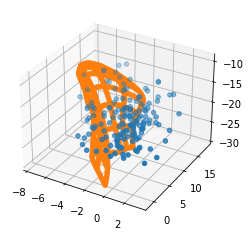

pedagogicalstartpts/startptslat2_lr0.0001_curvreg1_beta1_20220207-121623


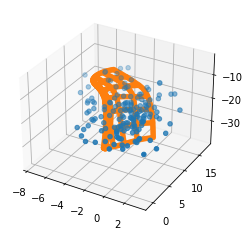

pedagogicalstartpts/startptslat2_lr0.0001_curvreg10_beta1_20220207-121716


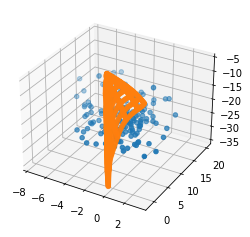

pedagogicalstartpts/startptslat2_lr0.0001_curvreg50_beta1_20220207-121810


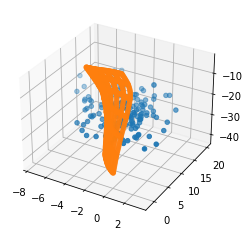

pedagogicalstartpts/startptslat2_lr0.0001_curvreg100_beta1_20220207-121904


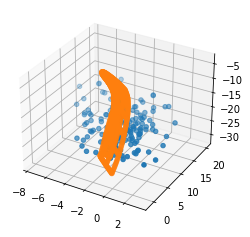

pedagogicalstartpts/startptslat2_lr0.0001_curvreg0_beta0.0001_20220207-121959


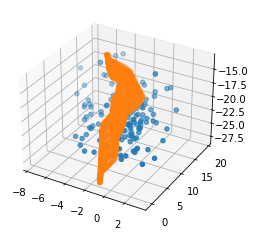

pedagogicalstartpts/startptslat2_lr0.0001_curvreg1_beta0.0001_20220207-122038


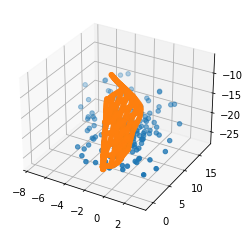

pedagogicalstartpts/startptslat2_lr0.0001_curvreg10_beta0.0001_20220207-122132


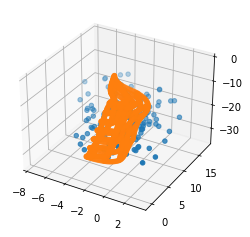

pedagogicalstartpts/startptslat2_lr0.0001_curvreg50_beta0.0001_20220207-122227


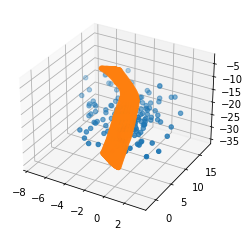

pedagogicalstartpts/startptslat2_lr0.0001_curvreg100_beta0.0001_20220207-122321


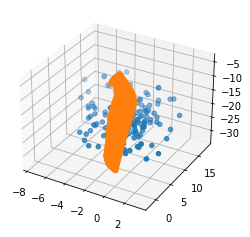

pedagogicalstartpts/startptslat2_lr0.0001_curvreg0_beta0.01_20220207-122414


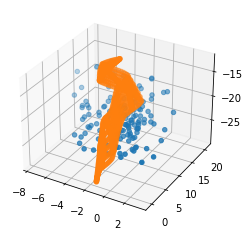

pedagogicalstartpts/startptslat2_lr0.0001_curvreg1_beta0.01_20220207-122453


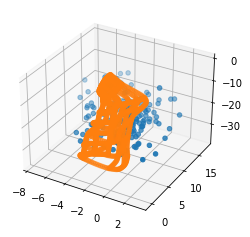

pedagogicalstartpts/startptslat2_lr0.0001_curvreg10_beta0.01_20220207-122547


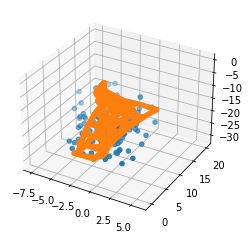

pedagogicalstartpts/startptslat2_lr0.0001_curvreg50_beta0.01_20220207-122644


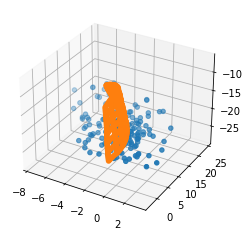

pedagogicalstartpts/startptslat2_lr0.0001_curvreg100_beta0.01_20220207-122738


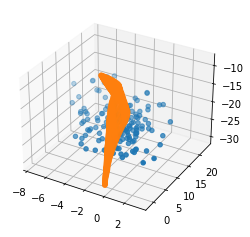

pedagogicalstartpts/startptslat2_lr0.0001_curvreg0_beta1.5_20220207-122834


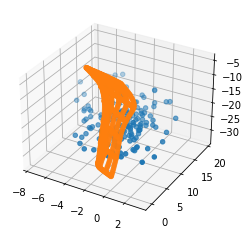

pedagogicalstartpts/startptslat2_lr0.0001_curvreg1_beta1.5_20220207-122913


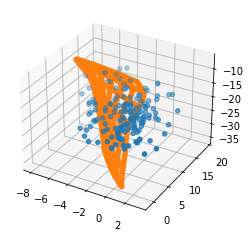

pedagogicalstartpts/startptslat2_lr0.0001_curvreg10_beta1.5_20220207-123008


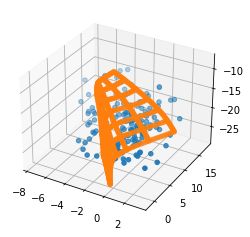

pedagogicalstartpts/startptslat2_lr0.0001_curvreg50_beta1.5_20220207-123102


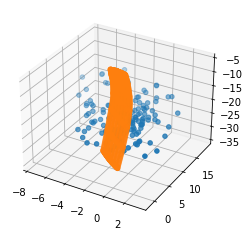

pedagogicalstartpts/startptslat2_lr0.0001_curvreg100_beta1.5_20220207-123157


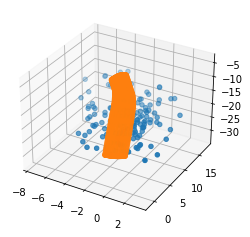

pedagogicalstartpts/startptslat2_lr0.0001_curvreg0_beta2_20220207-123255


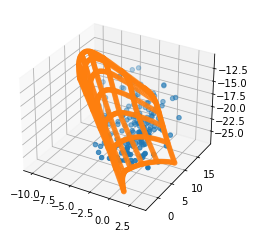

pedagogicalstartpts/startptslat2_lr0.0001_curvreg1_beta2_20220207-123335


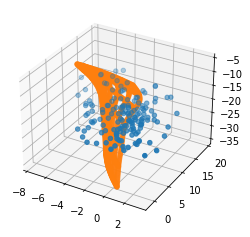

pedagogicalstartpts/startptslat2_lr0.0001_curvreg10_beta2_20220207-123429


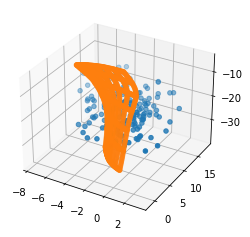

pedagogicalstartpts/startptslat2_lr0.0001_curvreg50_beta2_20220207-123523


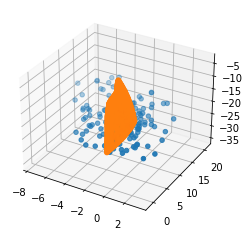

pedagogicalstartpts/startptslat2_lr0.0001_curvreg100_beta2_20220207-123622


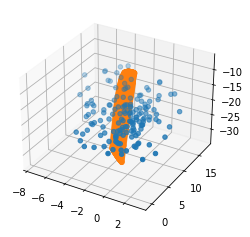

pedagogicalstartpts/startptslat2_lr0.0001_curvreg0_beta0.1_20220207-123717


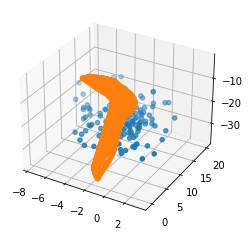

pedagogicalstartpts/startptslat2_lr0.0001_curvreg1_beta0.1_20220207-123757


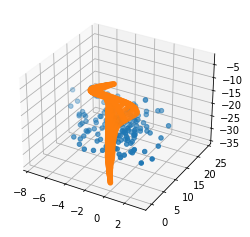

pedagogicalstartpts/startptslat2_lr0.0001_curvreg10_beta0.1_20220207-123852


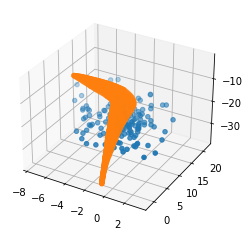

pedagogicalstartpts/startptslat2_lr0.0001_curvreg50_beta0.1_20220207-123948


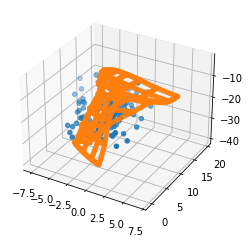

pedagogicalstartpts/startptslat2_lr0.0001_curvreg100_beta0.1_20220207-124042


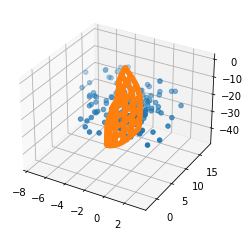

pedagogicalstartpts/startptslat2_lr1e-05_curvreg0_beta1_20220207-124137


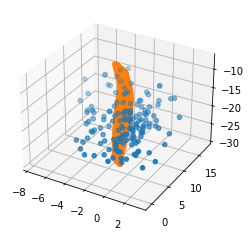

pedagogicalstartpts/startptslat2_lr1e-05_curvreg1_beta1_20220207-124217


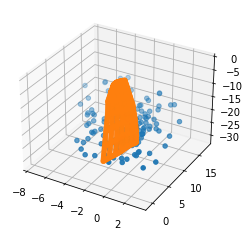

pedagogicalstartpts/startptslat2_lr1e-05_curvreg10_beta1_20220207-124312


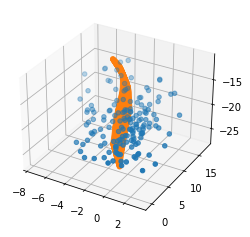

pedagogicalstartpts/startptslat2_lr1e-05_curvreg50_beta1_20220207-124406


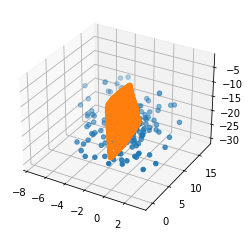

pedagogicalstartpts/startptslat2_lr1e-05_curvreg100_beta1_20220207-124501


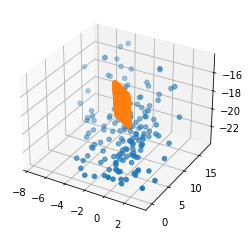

pedagogicalstartpts/startptslat2_lr1e-05_curvreg0_beta0.0001_20220207-124555


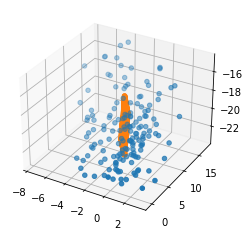

pedagogicalstartpts/startptslat2_lr1e-05_curvreg1_beta0.0001_20220207-124635


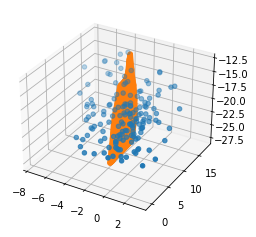

pedagogicalstartpts/startptslat2_lr1e-05_curvreg10_beta0.0001_20220207-124729


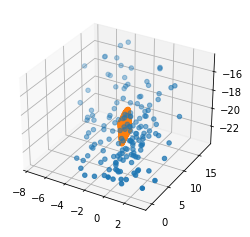

pedagogicalstartpts/startptslat2_lr1e-05_curvreg50_beta0.0001_20220207-124824


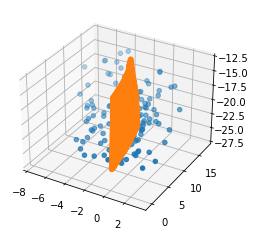

pedagogicalstartpts/startptslat2_lr1e-05_curvreg100_beta0.0001_20220207-124919


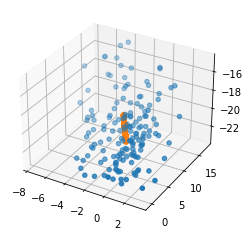

pedagogicalstartpts/startptslat2_lr1e-05_curvreg0_beta0.01_20220207-125013


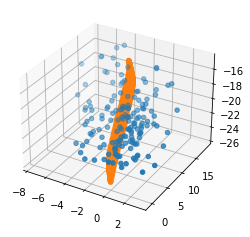

pedagogicalstartpts/startptslat2_lr1e-05_curvreg1_beta0.01_20220207-125053


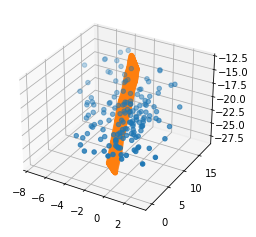

pedagogicalstartpts/startptslat2_lr1e-05_curvreg10_beta0.01_20220207-125147


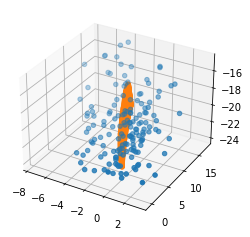

pedagogicalstartpts/startptslat2_lr1e-05_curvreg50_beta0.01_20220207-125242


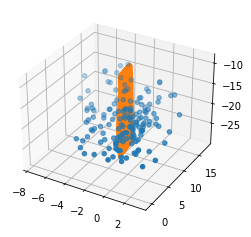

In [15]:
for i, modelpath in enumerate(all_models):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    print(modelpath)
    vae = lm.load_model(modelpath)
    embeds = vae.encode(torch.tensor(dataset,dtype=torch.float),
                       torch.tensor(np.zeros((len(dataset),0)),dtype=torch.float)
                       )[0].detach().cpu().numpy()
    pts = make_2d_grid_points(np.min(embeds[:,0]),np.max(embeds[:,0]),
                              np.min(embeds[:,1]),np.max(embeds[:,1]))
    readout = vae.decode(torch.tensor(pts,dtype=torch.float),
              torch.tensor(np.zeros((len(pts),0)),dtype=torch.float))[0].detach().cpu()
    
    ax.scatter(dataset[:,3],dataset[:,4],dataset[:,5]);
    ax.scatter(readout[:,3],readout[:,4],readout[:,5], alpha=0.5);
    plt.show()
    plt.close()

pedagogicalstartpts/startptslat2_lr0.0001_curvreg0_beta1_20220207-121542


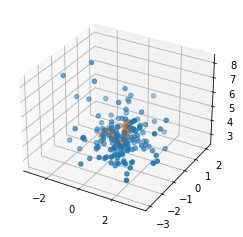

pedagogicalstartpts/startptslat2_lr0.0001_curvreg1_beta1_20220207-121623


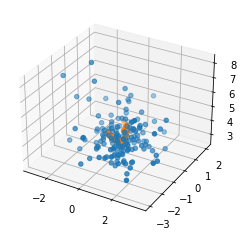

pedagogicalstartpts/startptslat2_lr0.0001_curvreg10_beta1_20220207-121716


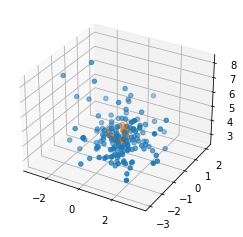

pedagogicalstartpts/startptslat2_lr0.0001_curvreg50_beta1_20220207-121810


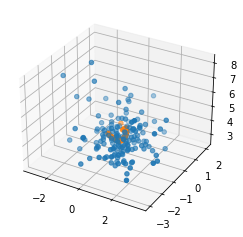

pedagogicalstartpts/startptslat2_lr0.0001_curvreg100_beta1_20220207-121904


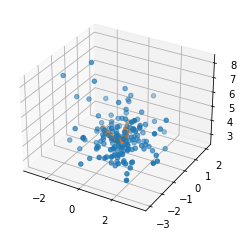

pedagogicalstartpts/startptslat2_lr0.0001_curvreg0_beta0.0001_20220207-121959


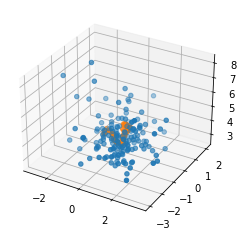

pedagogicalstartpts/startptslat2_lr0.0001_curvreg1_beta0.0001_20220207-122038


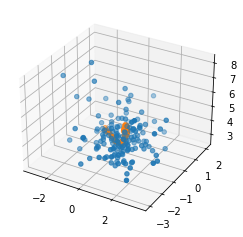

pedagogicalstartpts/startptslat2_lr0.0001_curvreg10_beta0.0001_20220207-122132


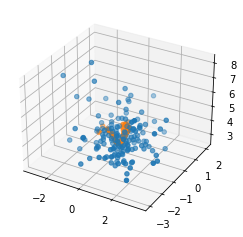

pedagogicalstartpts/startptslat2_lr0.0001_curvreg50_beta0.0001_20220207-122227


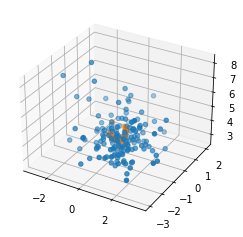

pedagogicalstartpts/startptslat2_lr0.0001_curvreg100_beta0.0001_20220207-122321


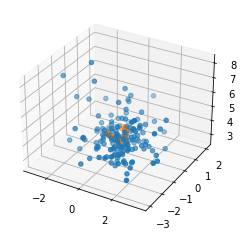

pedagogicalstartpts/startptslat2_lr0.0001_curvreg0_beta0.01_20220207-122414


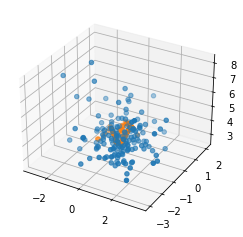

pedagogicalstartpts/startptslat2_lr0.0001_curvreg1_beta0.01_20220207-122453


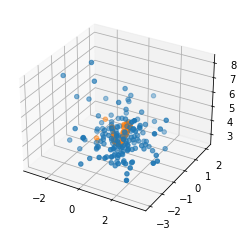

pedagogicalstartpts/startptslat2_lr0.0001_curvreg10_beta0.01_20220207-122547


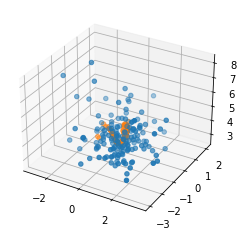

pedagogicalstartpts/startptslat2_lr0.0001_curvreg50_beta0.01_20220207-122644


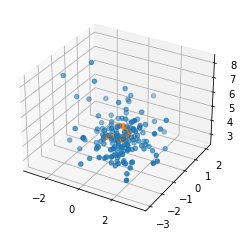

pedagogicalstartpts/startptslat2_lr0.0001_curvreg100_beta0.01_20220207-122738


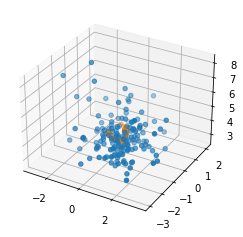

pedagogicalstartpts/startptslat2_lr0.0001_curvreg0_beta1.5_20220207-122834


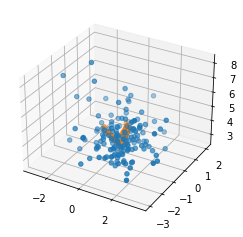

pedagogicalstartpts/startptslat2_lr0.0001_curvreg1_beta1.5_20220207-122913


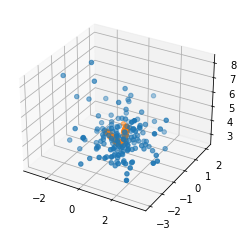

pedagogicalstartpts/startptslat2_lr0.0001_curvreg10_beta1.5_20220207-123008


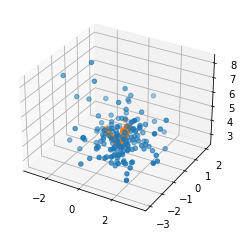

pedagogicalstartpts/startptslat2_lr0.0001_curvreg50_beta1.5_20220207-123102


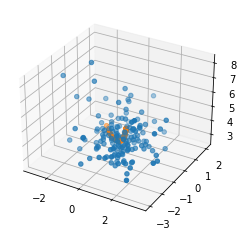

pedagogicalstartpts/startptslat2_lr0.0001_curvreg100_beta1.5_20220207-123157


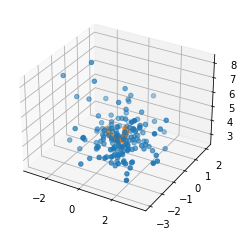

pedagogicalstartpts/startptslat2_lr0.0001_curvreg0_beta2_20220207-123255


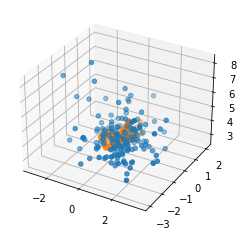

pedagogicalstartpts/startptslat2_lr0.0001_curvreg1_beta2_20220207-123335


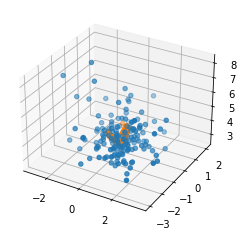

pedagogicalstartpts/startptslat2_lr0.0001_curvreg10_beta2_20220207-123429


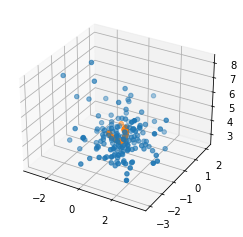

pedagogicalstartpts/startptslat2_lr0.0001_curvreg50_beta2_20220207-123523


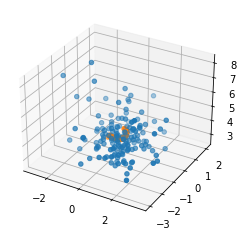

pedagogicalstartpts/startptslat2_lr0.0001_curvreg100_beta2_20220207-123622


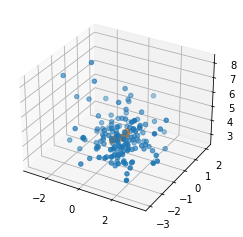

pedagogicalstartpts/startptslat2_lr0.0001_curvreg0_beta0.1_20220207-123717


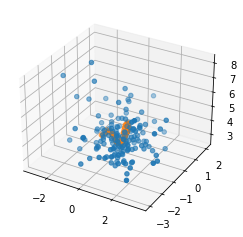

pedagogicalstartpts/startptslat2_lr0.0001_curvreg1_beta0.1_20220207-123757


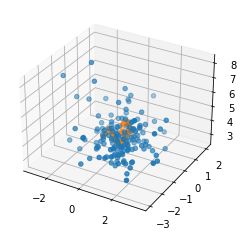

pedagogicalstartpts/startptslat2_lr0.0001_curvreg10_beta0.1_20220207-123852


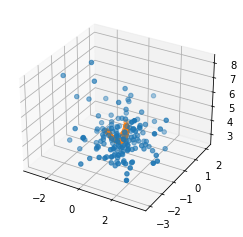

pedagogicalstartpts/startptslat2_lr0.0001_curvreg50_beta0.1_20220207-123948


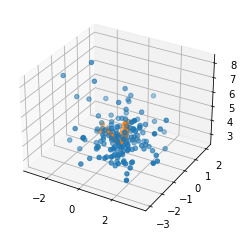

pedagogicalstartpts/startptslat2_lr0.0001_curvreg100_beta0.1_20220207-124042


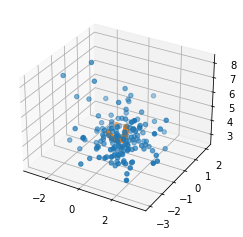

pedagogicalstartpts/startptslat2_lr1e-05_curvreg0_beta1_20220207-124137


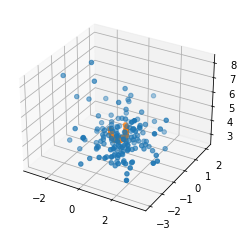

pedagogicalstartpts/startptslat2_lr1e-05_curvreg1_beta1_20220207-124217


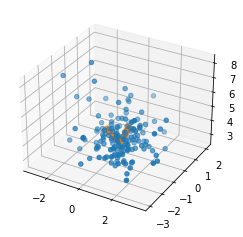

pedagogicalstartpts/startptslat2_lr1e-05_curvreg10_beta1_20220207-124312


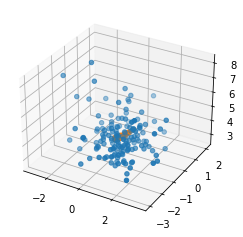

pedagogicalstartpts/startptslat2_lr1e-05_curvreg50_beta1_20220207-124406


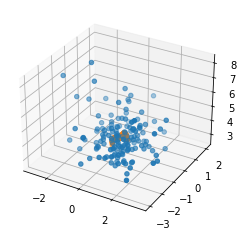

pedagogicalstartpts/startptslat2_lr1e-05_curvreg100_beta1_20220207-124501


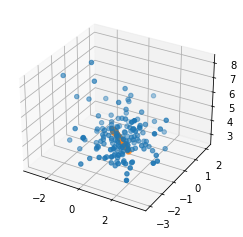

pedagogicalstartpts/startptslat2_lr1e-05_curvreg0_beta0.0001_20220207-124555


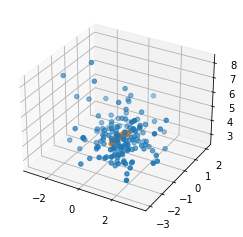

pedagogicalstartpts/startptslat2_lr1e-05_curvreg1_beta0.0001_20220207-124635


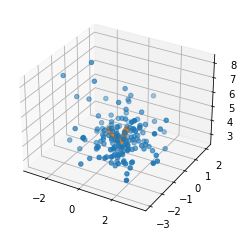

pedagogicalstartpts/startptslat2_lr1e-05_curvreg10_beta0.0001_20220207-124729


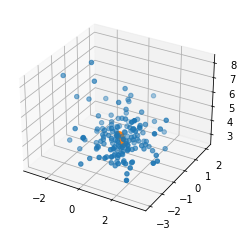

pedagogicalstartpts/startptslat2_lr1e-05_curvreg50_beta0.0001_20220207-124824


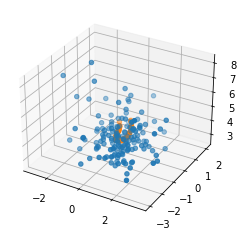

pedagogicalstartpts/startptslat2_lr1e-05_curvreg100_beta0.0001_20220207-124919


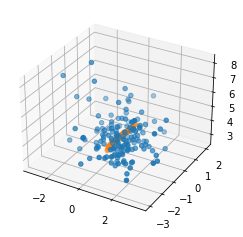

pedagogicalstartpts/startptslat2_lr1e-05_curvreg0_beta0.01_20220207-125013


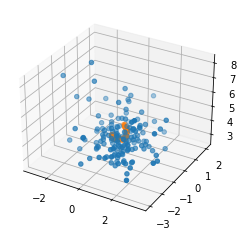

pedagogicalstartpts/startptslat2_lr1e-05_curvreg1_beta0.01_20220207-125053


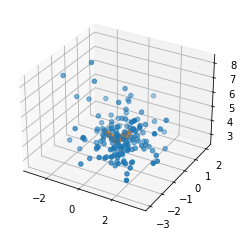

pedagogicalstartpts/startptslat2_lr1e-05_curvreg10_beta0.01_20220207-125147


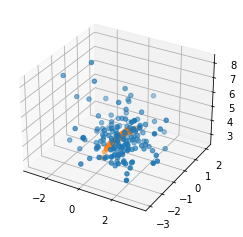

pedagogicalstartpts/startptslat2_lr1e-05_curvreg50_beta0.01_20220207-125242


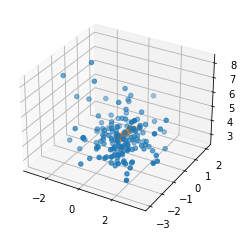

In [16]:

for i, modelpath in enumerate(all_models):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    print(modelpath)
    vae = lm.load_model(modelpath)
    embeds = vae.encode(torch.tensor(dataset,dtype=torch.float),
                       torch.tensor(np.zeros((len(dataset),0)),dtype=torch.float)
                       )[0]
    readout = vae.decode(embeds,
              torch.tensor(np.zeros((len(embeds),0)),dtype=torch.float))[0].detach().cpu()
    
    ax.scatter(dataset[:,0],dataset[:,1],dataset[:,2]);
    ax.scatter(readout[:,0],readout[:,1],readout[:,2], alpha=0.5);
    plt.show()
    plt.close()

pedagogicalstartpts/startptslat2_lr0.0001_curvreg0_beta1_20220207-121542


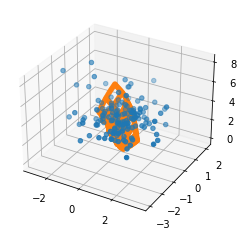

pedagogicalstartpts/startptslat2_lr0.0001_curvreg1_beta1_20220207-121623


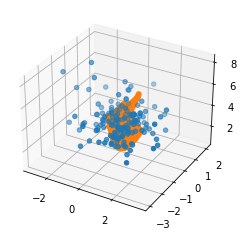

pedagogicalstartpts/startptslat2_lr0.0001_curvreg10_beta1_20220207-121716


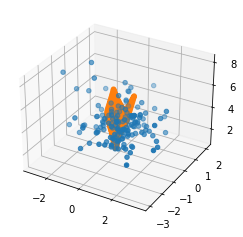

pedagogicalstartpts/startptslat2_lr0.0001_curvreg50_beta1_20220207-121810


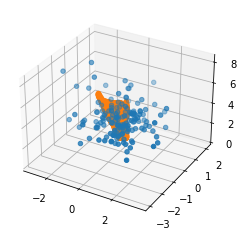

pedagogicalstartpts/startptslat2_lr0.0001_curvreg100_beta1_20220207-121904


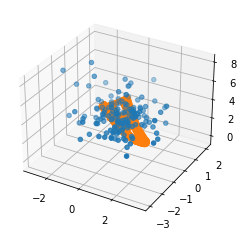

pedagogicalstartpts/startptslat2_lr0.0001_curvreg0_beta0.0001_20220207-121959


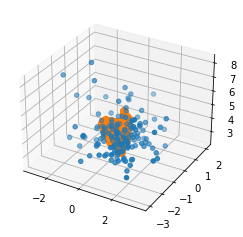

pedagogicalstartpts/startptslat2_lr0.0001_curvreg1_beta0.0001_20220207-122038


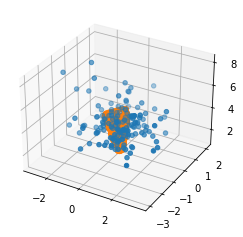

pedagogicalstartpts/startptslat2_lr0.0001_curvreg10_beta0.0001_20220207-122132


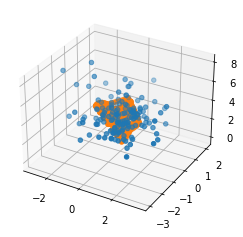

pedagogicalstartpts/startptslat2_lr0.0001_curvreg50_beta0.0001_20220207-122227


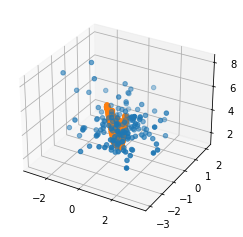

pedagogicalstartpts/startptslat2_lr0.0001_curvreg100_beta0.0001_20220207-122321


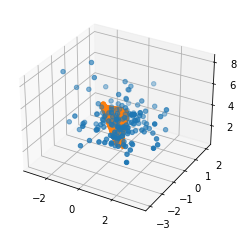

pedagogicalstartpts/startptslat2_lr0.0001_curvreg0_beta0.01_20220207-122414


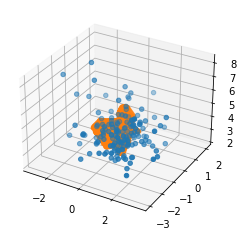

pedagogicalstartpts/startptslat2_lr0.0001_curvreg1_beta0.01_20220207-122453


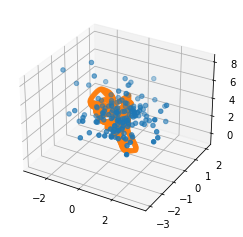

pedagogicalstartpts/startptslat2_lr0.0001_curvreg10_beta0.01_20220207-122547


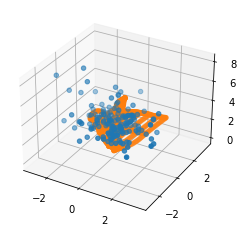

pedagogicalstartpts/startptslat2_lr0.0001_curvreg50_beta0.01_20220207-122644


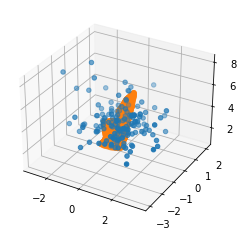

pedagogicalstartpts/startptslat2_lr0.0001_curvreg100_beta0.01_20220207-122738


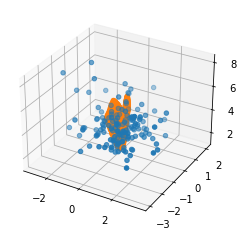

pedagogicalstartpts/startptslat2_lr0.0001_curvreg0_beta1.5_20220207-122834


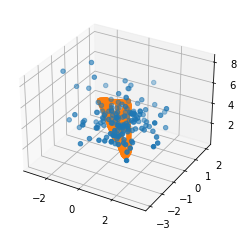

pedagogicalstartpts/startptslat2_lr0.0001_curvreg1_beta1.5_20220207-122913


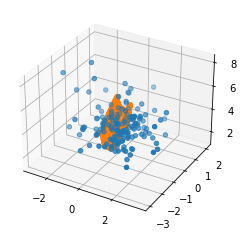

pedagogicalstartpts/startptslat2_lr0.0001_curvreg10_beta1.5_20220207-123008


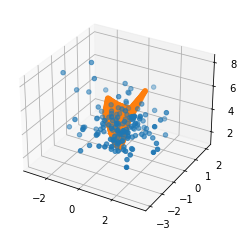

pedagogicalstartpts/startptslat2_lr0.0001_curvreg50_beta1.5_20220207-123102


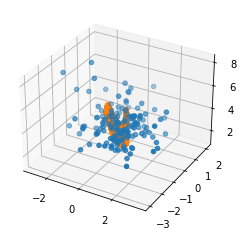

pedagogicalstartpts/startptslat2_lr0.0001_curvreg100_beta1.5_20220207-123157


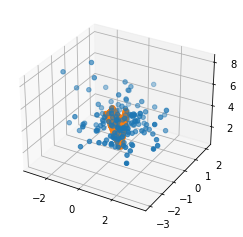

pedagogicalstartpts/startptslat2_lr0.0001_curvreg0_beta2_20220207-123255


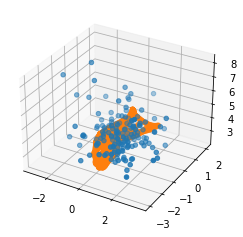

pedagogicalstartpts/startptslat2_lr0.0001_curvreg1_beta2_20220207-123335


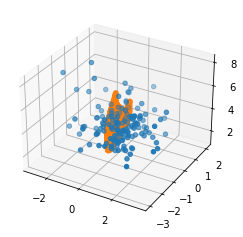

pedagogicalstartpts/startptslat2_lr0.0001_curvreg10_beta2_20220207-123429


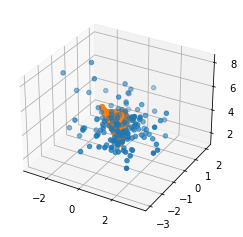

pedagogicalstartpts/startptslat2_lr0.0001_curvreg50_beta2_20220207-123523


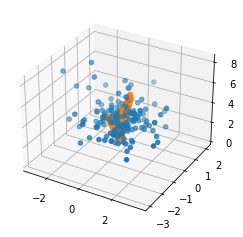

pedagogicalstartpts/startptslat2_lr0.0001_curvreg100_beta2_20220207-123622


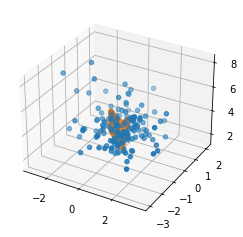

pedagogicalstartpts/startptslat2_lr0.0001_curvreg0_beta0.1_20220207-123717


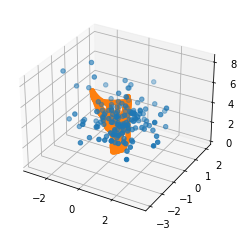

pedagogicalstartpts/startptslat2_lr0.0001_curvreg1_beta0.1_20220207-123757


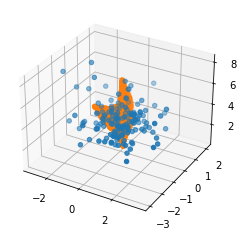

pedagogicalstartpts/startptslat2_lr0.0001_curvreg10_beta0.1_20220207-123852


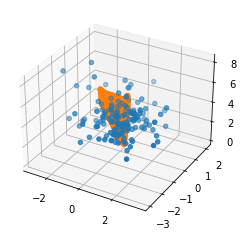

pedagogicalstartpts/startptslat2_lr0.0001_curvreg50_beta0.1_20220207-123948


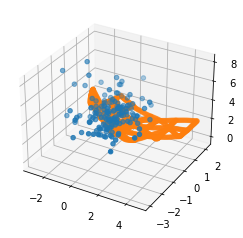

pedagogicalstartpts/startptslat2_lr0.0001_curvreg100_beta0.1_20220207-124042


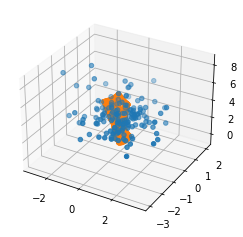

pedagogicalstartpts/startptslat2_lr1e-05_curvreg0_beta1_20220207-124137


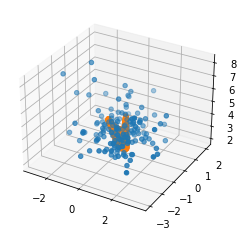

pedagogicalstartpts/startptslat2_lr1e-05_curvreg1_beta1_20220207-124217


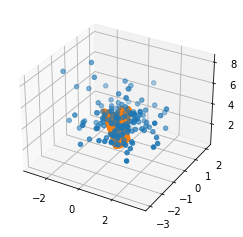

pedagogicalstartpts/startptslat2_lr1e-05_curvreg10_beta1_20220207-124312


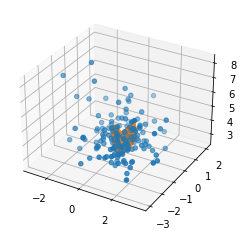

pedagogicalstartpts/startptslat2_lr1e-05_curvreg50_beta1_20220207-124406


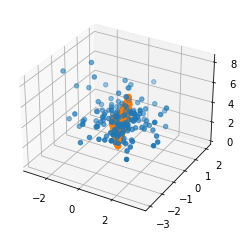

pedagogicalstartpts/startptslat2_lr1e-05_curvreg100_beta1_20220207-124501


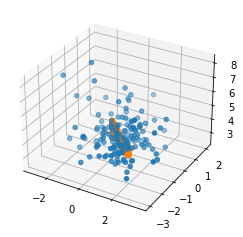

pedagogicalstartpts/startptslat2_lr1e-05_curvreg0_beta0.0001_20220207-124555


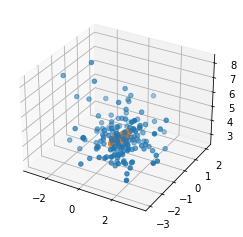

pedagogicalstartpts/startptslat2_lr1e-05_curvreg1_beta0.0001_20220207-124635


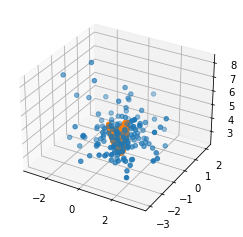

pedagogicalstartpts/startptslat2_lr1e-05_curvreg10_beta0.0001_20220207-124729


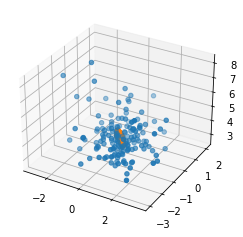

pedagogicalstartpts/startptslat2_lr1e-05_curvreg50_beta0.0001_20220207-124824


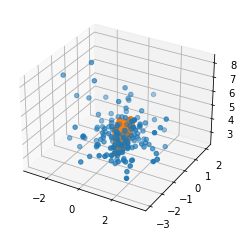

pedagogicalstartpts/startptslat2_lr1e-05_curvreg100_beta0.0001_20220207-124919


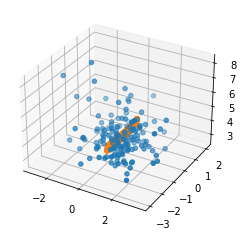

pedagogicalstartpts/startptslat2_lr1e-05_curvreg0_beta0.01_20220207-125013


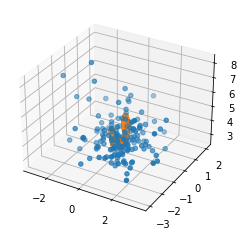

pedagogicalstartpts/startptslat2_lr1e-05_curvreg1_beta0.01_20220207-125053


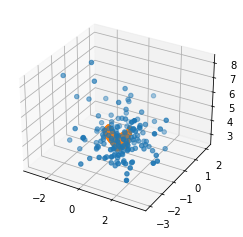

pedagogicalstartpts/startptslat2_lr1e-05_curvreg10_beta0.01_20220207-125147


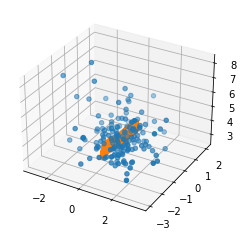

pedagogicalstartpts/startptslat2_lr1e-05_curvreg50_beta0.01_20220207-125242


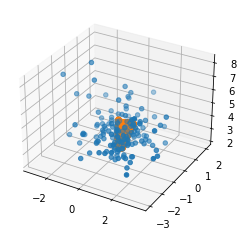

In [17]:

for i, modelpath in enumerate(all_models):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    print(modelpath)
    vae = lm.load_model(modelpath)
    embeds = vae.encode(torch.tensor(dataset,dtype=torch.float),
                       torch.tensor(np.zeros((len(dataset),0)),dtype=torch.float)
                       )[0].detach().cpu().numpy()
    pts = make_2d_grid_points(np.min(embeds[:,0]),np.max(embeds[:,0]),
                              np.min(embeds[:,1]),np.max(embeds[:,1]))
    readout = vae.decode(torch.tensor(pts,dtype=torch.float),
              torch.tensor(np.zeros((len(pts),0)),dtype=torch.float))[0].detach().cpu()
    
    ax.scatter(dataset[:,0],dataset[:,1],dataset[:,2]);
    ax.scatter(readout[:,0],readout[:,1],readout[:,2], alpha=0.5);
    plt.show()
    plt.close()